In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


sns.set(style='white', context='notebook', palette='deep')

/Users/suzukishinji/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/suzukishinji/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
train = pd.read_csv('/Users/suzukishinji/kaggle/MINIST/train.csv')
test = pd.read_csv('/Users/suzukishinji/kaggle/MINIST/test.csv')

In [3]:
Y_train = train['label'].values
X_train = train.drop('label', axis = 1)

In [4]:
del train

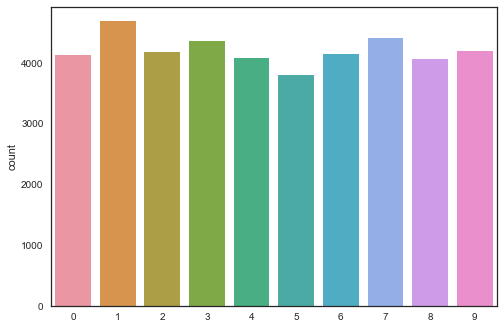

In [6]:
g = sns.countplot(Y_train)
#Y_train.value_counts()

In [7]:
X_train.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [8]:
test.isnull().any().describe()

count       784
unique        1
top       False
freq        784
dtype: object

In [9]:
X_train = X_train/255.0
test = test/255.0

In [10]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

In [11]:
Y_train = to_categorical(Y_train, num_classes = 10)

In [12]:
random_seed = 2

In [13]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state = random_seed)

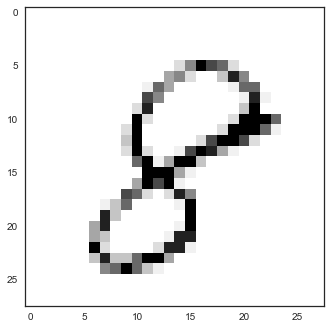

In [14]:
g = plt.imshow(X_train[0][:, :, 0])

In [15]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation = 'relu', input_shape = (28, 28, 1)))

In [16]:
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation = 'relu'))

In [17]:
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

In [18]:
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = (3, 3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2, 2), strides = (2, 2)))
model.add(Dropout(0.25))

In [19]:
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation = 'softmax'))

In [20]:
optimizer = RMSprop(lr = 0.001, rho = 0.9, epsilon = 1e-08, decay = 0.0)

In [21]:
model.compile(optimizer = optimizer , loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [22]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc', patience = 3, verbose = 1, factor = 0.5, min_lr = 0.00001)

In [23]:
epochs = 1
batch_size = 86

In [24]:
datagen = ImageDataGenerator(featurewise_center = False,
                            samplewise_center = False,
                            featurewise_std_normalization = False,
                            samplewise_std_normalization = False,
                            zca_whitening = False,
                            rotation_range = 10,
                            zoom_range = 0.1,
                            width_shift_range = 0.1,
                            height_shift_range = 0.1,
                            horizontal_flip = False,
                            vertical_flip = False)

datagen.fit(X_train)

In [25]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = batch_size), epochs = epochs, validation_data = (X_val, Y_val),verbose = 2, steps_per_epoch = X_train.shape[0] // batch_size, callbacks = [learning_rate_reduction])
#history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size = batch_size), epochs = epochs, validation_data = (X_val, Y_val),verbose = 2, steps_per_epoch = X_train.shape[0] // batch_size, callbacks = [learning_rate_reduction])

Epoch 1/1
 - 433s - loss: 0.4385 - acc: 0.8589 - val_loss: 0.0703 - val_acc: 0.9790


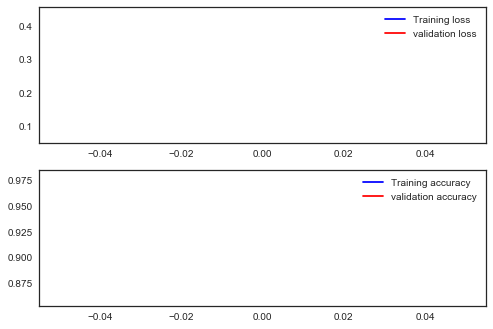

In [27]:
fig, ax = plt.subplots(2, 1)
ax[0].plot(history.history['loss'], color = 'b', label = 'Training loss')
ax[0].plot(history.history['val_loss'], color = 'r', label = 'validation loss', axes = ax[0])
legend = ax[0].legend(loc = 'best', shadow = True)

ax[1].plot(history.history['acc'], color = 'b', label = 'Training accuracy')
ax[1].plot(history.history['val_acc'], color = 'r', label = 'validation accuracy')
legend = ax[1].legend(loc = 'best', shadow = True)

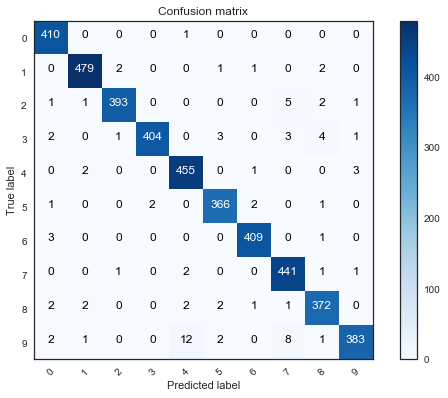

In [28]:
def plot_confusion_matrix(cm, classes, normalize = False, title = 'Confusion matrix', cmap = plt.cm.Blues):
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') /cm.sum(axis=1)[:, np.newaxis]
        
    thresh = cm.max()/2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j , i, cm[i, j], horizontalalignment = 'center', color = 'white' if cm[i, j] > thresh else 'black')
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis = 1)
Y_true = np.argmax(Y_val, axis = 1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes = range(10))

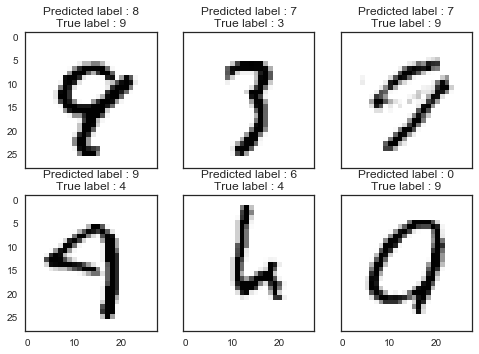

In [29]:
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex = True, sharey = True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]).reshape((28, 28)))
            ax[row, col].set_title('Predicted label : {}\nTrue label : {}'.format(pred_errors[error], obs_errors[error]))
            n +=1

Y_pred_errors_prob = np.max(Y_pred_errors, axis = 1)
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis = 1))
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

sorted_dela_errors = np.argsort(delta_pred_true_errors)

most_important_errors = sorted_dela_errors[-6:]
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [34]:
results = model.predict(test)

In [38]:
test.shape

(28000, 28, 28, 1)

In [35]:
results.shape

(28000, 10)

In [39]:
results

array([[8.0850447e-07, 1.8708822e-07, 9.9999082e-01, ..., 2.9504367e-06,
        1.5250994e-07, 5.2935154e-09],
       [9.9997187e-01, 1.4652676e-09, 2.3881854e-05, ..., 1.5728260e-07,
        8.8637114e-07, 1.9434715e-06],
       [7.1963309e-06, 4.8251142e-05, 2.3384790e-05, ..., 5.0812389e-04,
        9.7288024e-03, 9.8250210e-01],
       ...,
       [7.9983010e-08, 8.6453731e-08, 5.1473279e-07, ..., 1.2610828e-06,
        1.5650337e-06, 1.1608939e-07],
       [7.3991887e-06, 2.3930168e-06, 5.5188281e-07, ..., 1.7272217e-02,
        1.5451427e-05, 9.8065186e-01],
       [1.9677286e-07, 1.0344075e-07, 9.9999022e-01, ..., 2.6965725e-07,
        4.5625729e-06, 3.2207499e-08]], dtype=float32)

In [40]:
results = np.argmax(results, axis = 1)

In [41]:
results.shape

(28000,)

In [42]:
results = pd.Series(results, name = 'Label')

In [43]:
submission = pd.concat([pd.Series(range(1, 28001), name = 'ImageId'), results], axis = 1)
submission.to_csv('cnn_minst_datagen.csv', index = False)